In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
# Define the discrete action space
def define_action_space(n_actions):
  theta = np.linspace(0, 2*np.pi, n_actions)
  return np.array([np.cos(theta), np.sin(theta)]).T

In [24]:
# P(goal1 | xi)
# How likely the human thinks goal1 is given the robot's trajectory
# See the lecture on Shared Autonomy for the derivation of this equation
def P_goal1(start_state, curr_state, action, goal1, goal2, beta, prior):
  next_state = np.copy(curr_state) + action
  next2goal1 = np.linalg.norm(goal1 - next_state)
  next2goal2 = np.linalg.norm(goal2 - next_state)
  start2next = np.linalg.norm(next_state - start_state)
  start2goal1 = np.linalg.norm(goal1 - start_state)
  start2goal2 = np.linalg.norm(goal2 - start_state)
  p_goal1 = np.exp(-beta * start2next - beta * next2goal1) / np.exp(-beta * start2goal1) * prior[0]
  p_goal2 = np.exp(-beta * start2next - beta * next2goal2) / np.exp(-beta * start2goal2) * prior[1]
  belief = np.array([p_goal1, p_goal2]) / (p_goal1 + p_goal2)
  return belief[0]

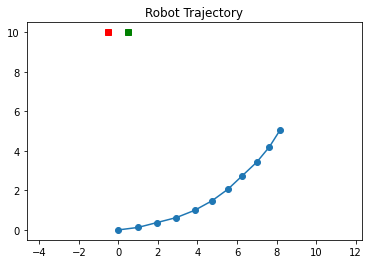

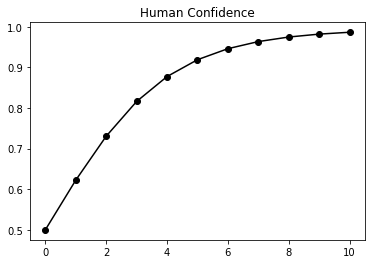

In [70]:
## Part 1. Optimizing only for legible motion

# hyperparameters that you tune
goal1 = np.array([+0.5, 10])
goal2 = np.array([-0.5, 10])
start = np.array([0.0, 0.0])
action_space = define_action_space(51)
beta = 5.0
prior = [0.5, 0.5]
trajectory_length = 10

# initialize the trajectory and state
xi = [list(start)]
b = [prior[0]]
s = np.copy(start)

for timestep in range(trajectory_length):

  # let's search over all actions to find one that maximizes 
  # the human's belief in goal 1
  belief_star = 0.0
  action_star = None
  for action in action_space:
    belief = P_goal1(start, s, action, goal1, goal2, beta, prior)
    # if the proposed action is more legible, we use it!
    if belief > belief_star:
      action_star = np.copy(action)
      belief_star = belief

  # update for next timestep
  s += action_star
  xi.append(list(s))
  b.append(belief_star)

# plot the trajectory
xi = np.array(xi)
plt.plot(xi[:,0], xi[:,1], 'o-')
plt.plot(goal1[0], goal1[1], 'gs')
plt.plot(goal2[0], goal2[1], 'rs')
plt.axis('equal')
plt.title('Robot Trajectory')
plt.show()

# plot the human's confidence
plt.plot(range(trajectory_length+1), b, 'ko-')
plt.title('Human Confidence')
plt.show()

In [40]:
# Value function
# V(s, goal) = distance from state to goal
def V(state, goal):
  return np.linalg.norm(goal - state)

In [41]:
# Q function
# Q(s, a, goal) = C(s, a) + V(s', goal)
def Q(state, action, goal):
  state1 = state + action
  return np.linalg.norm(action) + V(state1, goal)

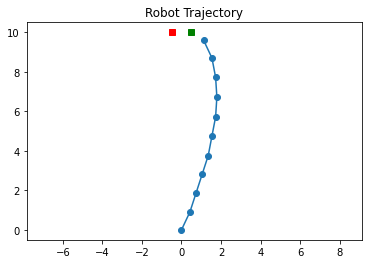

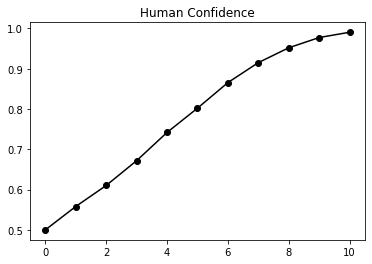

In [71]:
## Part 2. Optimizing for legible motion with performance constraints
## Note: we are working with costs, not rewards! Our cost is the distance to the goal.

# hyperparameters that you tune
goal1 = np.array([+0.5, 10])
goal2 = np.array([-0.5, 10])
start = np.array([0.0, 0.0])
action_space = define_action_space(51)
beta = 5.0
prior = [0.5, 0.5]
trajectory_length = 10
eta = 0.1

# initialize the trajectory and state
xi = [list(start)]
b = [prior[0]]
s = np.copy(start)

for timestep in range(trajectory_length):

  # start our search with the most efficient action
  # this action moves directly towards the goal
  action_star = (goal1 - s) / np.linalg.norm(goal1 - s)
  if np.linalg.norm(goal1 - s) < 1.0:
    action_star = (goal1 - s)
  belief_star = P_goal1(start, s, action_star, goal1, goal2, beta, prior)

  # let's search over all actions to find one that maximizes 
  # the human's belief in goal 1
  for action in action_space:
    belief = P_goal1(start, s, action, goal1, goal2, beta, prior)
    loss = Q(s, action, goal1) - V(s, goal1)
    # if the proposed action is more legible and efficient, we use it!
    if belief > belief_star and loss < eta:
      action_star = np.copy(action)
      belief_star = belief

  # update for next timestep
  s += action_star
  xi.append(list(s))
  b.append(belief_star)

# plot the trajectory
xi = np.array(xi)
plt.plot(xi[:,0], xi[:,1], 'o-')
plt.plot(goal1[0], goal1[1], 'gs')
plt.plot(goal2[0], goal2[1], 'rs')
plt.axis('equal')
plt.title('Robot Trajectory')
plt.show()

# plot the human's confidence
plt.plot(range(trajectory_length+1), b, 'ko-')
plt.title('Human Confidence')
plt.show()